In [1]:
from sklearn.metrics import f1_score
import numpy as np 
import pandas as pd
import glob
import matplotlib.pyplot as plt


In [2]:
files = glob.glob('run*.csv')
files.sort()
files

['run-no_attention_resnet_-tag-Loss_train.csv',
 'run-sgd3_head1-tag-Loss_train.csv',
 'run-v3_hard_sel-tag-Loss_train.csv',
 'run-v3_hard_sel_10-tag-Loss_train.csv',
 'run-v4_mhsa_test-tag-Loss_train.csv',
 'run-whole_attention_whole_attention_resnet_-tag-Loss_train.csv',
 'run-whole_attention_whole_attention_v1_-tag-Loss_train.csv']

In [3]:
names = ["global no attention",
         "regional soft attention (head 1)", 
         "regional hard attention (select 5)",
         "regional hard attention (select 10)",
         "regional soft attention (head 8)",
         "global soft attention (resnet encoder)",
         "global soft attention (mobile net encoder)"]

In [4]:
names = ["GNA",
         "RSA (head 5)", 
         "RHA (select 5)",
         "RHA (select 10)",
         "RSA (head 8)",
         "GSA (resnet)",
         "GSA (mobilenet)"]

## Learning Curve


In [5]:
def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return smoothed

In [6]:
# df = pd.read_csv(files[5])
# df.head()

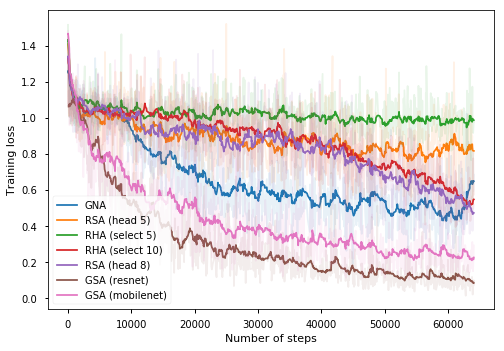

<Figure size 576x396 with 0 Axes>

In [7]:
plt.style.use('seaborn-notebook')
# plt.style.use('seaborn')

def plot_training(data_files,names,smooth_weight=0.91,ylim=None):
    losses = []
    losses_smoothed = []
    xs = []
    for data_file in data_files:
        df = pd.read_csv(data_file)
        loss = np.array(df['Value'])
        losses.append(loss)

        loss_smoothed = smooth(loss, smooth_weight)

        losses_smoothed.append(loss_smoothed)
        xs.append(np.array(df['Step']))

    plt.figure()

    for (x,loss,loss_smoothed,name) in zip(xs,losses,losses_smoothed,names):
        p = plt.plot(x,loss,alpha=0.1)
        plt.plot(x,loss_smoothed,label=name,c=p[0].get_color())
    plt.legend()
    if ylim:
        plt.ylim(ylim)
    # plt.title("Loss vs Steps")
    plt.xlabel("Number of steps")
    plt.ylabel("Training loss")
    plt.savefig('./figures/loss.png',dpi=300,bbox_inches='tight')

    plt.figure()

plot_training(files,names)

## F1 Score

In [35]:
prediction_dir = '../saved_predictions/'
files = glob.glob()

In [52]:
l = []
for fn in files:
    l.append(fn.split('-')[1]+'39')
l[1]="bdd_oia_head1_39"
l[-2] = "whole_attention_resnet_39"
l[-1] = "whole_attention_v1_39"
l

['no_attention_resnet_39',
 'bdd_oia_head1_39',
 'v3_hard_sel39',
 'v3_hard_sel_1039',
 'v4_mhsa_test39',
 'whole_attention_resnet_39',
 'whole_attention_v1_39']

In [78]:
action_pred_files = [prediction_dir + 'pred_action_' +i + '.npy' for i in l]
action_trgt_files = [prediction_dir + 'trgt_action_' +i + '.npy' for i in l]
action_predictions = [np.load(f) for f in action_pred_files]
action_targets = [np.load(f) for f in action_trgt_files]


In [79]:
ComputeClsAcc(action_predictions[-1],action_targets[-1])

(array([0.7737838 , 0.78207354, 0.70714604, 0.71908425]),
 array([0.78087649, 0.7892873 , 0.76626826, 0.75520142]))

In [95]:
reason_pred_files = [prediction_dir + 'pred_reason_' +i + '.npy' for i in l]
reason_trgt_files = [prediction_dir + 'trgt_reason_' +i + '.npy' for i in l]
reason_predictions = [np.load(f) for f in reason_pred_files]
reason_targets = [np.load(f) for f in reason_trgt_files]

In [105]:
def ComputeClsAcc(target, pred):
    """
    target - target array, (N, cls)
    pred - prediction array (N, cls)
    """
    f1_macro = []
    f1_micro = []
    for cls in range(target.shape[1]):
        target_ = target[:, cls]
        pred_ = pred[:, cls]
        f1_macro.append(f1_score(target_, pred_, average='macro'))
        f1_micro.append(f1_score(target_, pred_, average='micro'))
    f1_macro = np.array(f1_macro)
    f1_micro = np.array(f1_micro)

    return f1_macro, f1_micro

f1_all_fn = lambda x,y: f1_score(x,y,average='samples')

In [108]:
action_f1_macro_means = []
action_f1_micro_means = []
action_f1_alls = []

reason_f1_macro_means = []
reason_f1_micro_means = []
reason_f1_alls = []

for (i,name) in enumerate(names):

    action_pred = np.load(prediction_dir + 'pred_action_' + l[i] + '.npy')
    action_trgt = np.load(prediction_dir + 'trgt_action_' + l[i] + '.npy')

    reason_pred = np.load(prediction_dir + 'pred_reason_' + l[i] + '.npy')
    reason_trgt = np.load(prediction_dir + 'trgt_reason_' + l[i] + '.npy')

    action_f1_macro, action_f1_micro = ComputeClsAcc(action_pred, action_trgt)
    action_f1_macro_means.append(action_f1_macro.mean()) 
    action_f1_micro_means.append(action_f1_micro.mean())
    action_f1_alls.append(f1_all_fn(action_pred, action_trgt))


    reason_f1_macro, reason_f1_micro = ComputeClsAcc(reason_pred, reason_trgt)
    reason_f1_macro_means.append(reason_f1_macro.mean()) 
    reason_f1_micro_means.append(reason_f1_micro.mean())
    reason_f1_alls.append(f1_all_fn(reason_pred, reason_trgt))

In [109]:
import pandas as pd

In [112]:
stats = {
        "model":names, 
        "decision mF1 (macro)":action_f1_macro_means,
        "decision mF1 (micro)":action_f1_micro_means,
        "decision F1_all":action_f1_alls,
        "explanation mF1 (macro)":reason_f1_macro_means,
        "explanation mF1 (micro)":reason_f1_micro_means,
        "explanation F1_all":reason_f1_alls
        }
stat_df = pd.DataFrame(stats)
stat_df

,model,decision mF1 (macro),decision mF1 (micro),decision F1_all,explanation mF1 (macro),explanation mF1 (micro),explanation F1_all
0,GNA,0.705827,0.759960,0.660391,0.561263,0.888256,0.351803
1,RSA (head 1),0.595255,0.630478,0.475999,0.505557,0.877021,0.126863
2,RHA (select 5),0.571859,0.636897,0.493744,0.482107,0.884357,0.047044
3,RHA (select 10),0.565012,0.619854,0.495339,0.498925,0.886697,0.123302
4,RSA (head 8),0.608134,0.681054,0.542208,0.554345,0.887160,0.330127
5,GSA (resnet),0.750288,0.780876,0.703607,0.644186,0.901811,0.524956
6,GSA (mobilenet),0.745522,0.772908,0.704614,0.641726,0.908177,0.531498


In [114]:
stat_df.to_csv('./stat.csv',index=False)